In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import skellam
import matplotlib.pyplot as plt

In [2]:
#Create a Dataframe with 4 season
Data10=pd.read_csv("../Data/2009-2010.csv")
Data9=pd.read_csv("../Data/2008-2009.csv")
Data8=pd.read_csv("../Data/2007-2008.csv")
Data7=pd.read_csv("../Data/2006-2007.csv")
Data=pd.concat([Data7,Data8,Data9,Data10],sort=False,ignore_index=True)
Data=Data[['HomeTeam','AwayTeam','FTHG','FTAG','FTR']]
Data.columns=['Home','Away','HG','AG','Result']
Out=["Lecce","Messina","Ascoli","Reggina","Empoli","Torino"]
for out in Out:
    Data = Data.loc[Data.Home != out]
    Data = Data.loc[Data.Away != out]
Data=Data.reset_index()
Team=Data.Home.value_counts().index
Data['diff_score']=Data['HG']-Data['AG']


In [3]:
#Create a dataframe with the coefficients to update
coef=pd.DataFrame({'Team':Team})
coef['Att']=np.random.normal(0,0.01,len(coef))
coef['Dif']=np.random.normal(0,0.01,len(coef))
coef.iloc[0]['Att']=coef.iloc[0]['Att'] -sum(coef['Att'].values)
coef.iloc[0]['Dif']=coef.iloc[0]['Dif'] -sum(coef['Dif'].values)
#In order to have identifiability of the covariates 
coef=coef.set_index('Team').sort_index()

delta = np.random.normal(0,0.01)
coef

C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Att,Dif
Team,,
Atalanta,-0.005698,-0.002267
Bari,0.021949,-0.012513
Bologna,-0.017813,-0.001114
Cagliari,0.001899,-0.010726
Catania,0.021386,-0.019298
Chievo,-0.012586,-0.001240
Fiorentina,0.034527,0.001340
Genoa,-0.006368,-0.007729
Inter,-0.002533,-0.019153


In [4]:
#Function to calculate the means for the Poisson distribution
def score_coef(att,dif,delta,Data):
    mu1=np.array([])
    mu2=np.array([])
    for i in Data.index:
        m1=np.exp(delta+att.loc[Data.loc[i].Home]-dif.loc[Data.loc[i].Away])
        m2=np.exp(att.loc[Data.loc[i].Away]-dif.loc[Data.loc[i].Home])
        mu1=np.append(mu1,m1)
        mu2=np.append(mu2,m2)
    return mu1, mu2

In [5]:
def log_prior (coef_att,coef_dif,delta):
    e= norm.logpdf(delta, loc=0, scale=0.1)
    for i in range(len(coef_att)):
        e=+ norm.logpdf(coef_att[i], loc=0, scale=0.1)+ norm.logpdf(coef_dif[i], loc=0, scale=0.01)
    return e

In [6]:
#Define The ZPD probability distribution
def FZPD(z,p,lambda1,lambda2):
    if z==0:
        return (p +(1-p)*skellam.pmf(z,lambda1,lambda2))
    else : 
        return (1-p)*skellam.pmf(z,lambda1,lambda2)

In [7]:
#Get the log likelihood
def log_likeli(lambda1,lambda2,score,p):
    D=0
    for i in range(len(score)):
        D+=np.log(FZPD(score.iloc[i], p, lambda1.iloc[i], lambda2.iloc[i]))
    return D

In [8]:
#Calculate our unnormalised log posterior
def log_tot (X):
    coef_att=np.concatenate(([-sum(X[1:20])],X[1:20]))
    coef_def=np.concatenate(([-sum(X[20:39])],X[20:39]))
    H=X[0]
    p=X[39]
    N=log_prior(coef_att,coef_def,H)
    coef['i1']=coef_att
    coef['i2']=coef_def
    L1,L2=score_coef(coef['i1'],coef['i2'],H,Data)
    Data['j1']=L1
    Data['j2']=L2
    N+=log_likeli(Data['j1'],Data['j2'],Data['diff_score'],p)
    return N 

In [9]:
def MCMC(max_iter,theta0,Data): 
    #create vectors to save coef and means at each iteration
    totnameatt= list()
    totnamedef= list()
    theta_t = theta0 
    liste=range(40)
    ret=0;
    coef['Sum_Att']=coef['Att']
    coef['Sum_Dif']=coef['Dif']
    for k in range(max_iter):
       #choose randomly 5 coef to be updated
        a1, a2, a3, a4, a5 =np.random.choice(liste, 5,replace=False)
        v=0.1
        b1=np.random.normal(0,v)
        b2=np.random.normal(0,v)
        b3=np.random.normal(0,v)
        b4=np.random.normal(0,v)
        b5=np.random.normal(0,v)
        
        theta2_t=np.copy(theta_t)
        
        theta2_t[a1]+=b1
        theta2_t[a2]+=b2
        theta2_t[a3]+=b3
        theta2_t[a4]+=b4
        theta2_t[a5]+=b5
        
        # Does not want to have negative probability.
        if theta2_t[39]<0:
            theta2_t[39]=0.05
            

        coef['New_Att']=np.concatenate(([-sum(theta2_t[1:20])],theta2_t[1:20]))
        coef['New_Dif']=np.concatenate(([-sum(theta2_t[20:39])],theta2_t[20:39]))
        
        
        mu1 ,mu2=score_coef(coef['New_Att'],coef['New_Dif'],theta2_t[0],Data)
        Data['new_mu1']=mu1
        Data['new_mu2']=mu2
        #Calculate unormalised log posterior

        L1=log_tot(theta_t)

        L2=log_tot(theta2_t)
        
        #Here we have taken the log of the difference of the proposal and transorm back
        alpha= min(1,np.exp(L2-L1))
        u=np.random.uniform(0,1)
        
        if u<alpha:
            name_att = "iter"+str(ret)+"att"
            name_def= "iter"+str(ret)+"def"
            coef[name_att]=coef['New_Att']
            coef[name_def]=coef['New_Dif']
            Data[name_att]=Data['new_mu1']
            Data[name_def]=Data['new_mu2']
            Data['mu1']=Data['new_mu1']
            Data['mu2']=Data['new_mu2']
            theta_t=np.copy(theta2_t)
            ret+=1
            totnameatt.append(name_att)
            totnamedef.append(name_def)
            print(k)
            coef['Sum_Att']+=coef['New_Att']
            coef['Sum_Dif']+=coef['New_Dif']
        
        
    if ret!=0:
        coef['Sum_Att']=coef['Sum_Att']/ret
        coef['Sum_Dif']=coef['Sum_Dif']/ret
    
    return coef, theta_t[0], theta_t[39],ret,Data,totnameatt,totnamedef


In [10]:
p= np.random.rand()
theta0=np.concatenate(([[delta],coef['Att'][1:20],coef['Dif'][1:20],[p]]))


In [11]:
Coef_club, delta1,prob,it,Data1, name_Att,name_Dif=MCMC(2000,theta0,Data)


0
2
3
5
6
9
11
14
15
19
25
28
30
31
33
41
44
45
46
48
55
58
61
73
74
75
77
78
79
80
83
84
86
89
90
92
93
94
96
106
107
108
112
113
117
119
123
128
132
136
137
140
145
147
150
151
154
156
162
168
169
172
173
180
181
188
189
190
192
195
199
200
206
211
213
216
224
225
226
230
236
247
249
255
282
286
288
297
306
309
310
313
325
339
342
344
347
351
356
362
365
366
379
381
415
416
420
429
470
471
477
481
500
508
514
517
521
527
532
538
539
544
545
552
564
565
566
570
584
593
607
609
627
630
633
634
636
638
650
656
664
667
675
679
681
686
703
704
714
722
724
725
731
734
735
738
752
757
762
777
787
793
801
807
810
812
813
820
821
823
838
839
842
843
849
852
860
866
867
870
871
879
885
886
888
890
891
898
910
916
917
921
925
928
931
937
946
948
950
951
969
972
976
980
983
987
991
999
1002
1021
1022
1023
1024
1026
1033
1034
1039
1045
1056
1068
1074
1075
1079
1085
1087
1088
1093
1095
1109
1117
1119
1123
1124
1154
1160
1162
1163
1198
1204
1208
1209
1210
1213
1214
1228
1242
1247
1257
1258
1260
126

In [13]:
Coef_club['Home_adv']=delta1
Coef_club['prob']=prob
Coef_club.to_csv('Coef_MCMC_ZPD.csv')

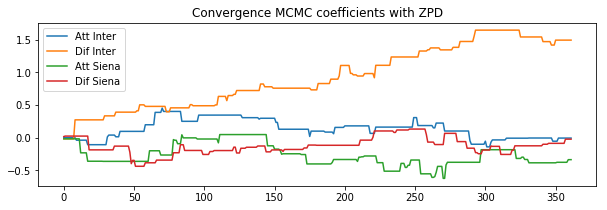

In [14]:
#Plot the evolution of Attacking and difensive Coefficients of Inter and Siena 
def vect(coef):
    
    vect_att_i=[]
    vect_def_i=[]
    vect_att_s=[]
    vect_def_s=[]
    for i in range(it):
        vect1=[]
        vect2=[]
        vect3=[]
        vect4=[]
        col_att = "iter"+str(i)+"att"
        col_def = "iter"+str(i)+"def"
        vect1.append(coef[col_att][8])
        vect2.append(coef[col_def][8])
        vect3.append(coef[col_att][18])
        vect4.append(coef[col_def][18])
        vect_att_i.append(vect1)
        vect_def_i.append(vect2)
        vect_att_s.append(vect3)
        vect_def_s.append(vect4)
    plt.figure(figsize=(10,3))
    plt.plot(vect_att_i, label='Att Inter')
    plt.plot(vect_def_i,label='Dif Inter')
    plt.plot(vect_att_s, label='Att Siena')
    plt.plot(vect_def_s,label='Dif Siena')
    plt.legend(loc='upper left')
    plt.title('Convergence MCMC coefficients with ZPD')
    plt.savefig('MCMC_ZPD.png')
    plt.show()
    return 
vect(Coef_club)

In [12]:
Coef_club

,Att,Dif,Sum_Att,Sum_Dif,New_Att,New_Dif,i1,i2,iter0att,iter0def,...,iter357att,iter357def,iter358att,iter358def,iter359att,iter359def,iter360att,iter360def,iter361att,iter361def
Team,,,,,,,,,,,,,,,,,,,,,
Atalanta,-0.005698,-0.002267,-0.027717,-0.131890,0.133046,-0.016910,0.133046,-0.016910,-0.134297,0.108440,...,-0.008875,-0.005209,0.020797,-0.126997,0.037375,-0.100162,0.007785,0.150506,-0.073200,0.044683
Bari,0.021949,-0.012513,0.247040,-0.048888,0.534615,-0.209563,0.534615,-0.209563,0.021949,-0.012513,...,0.265198,-0.182316,0.265198,-0.182316,0.265198,-0.182316,0.384583,-0.182316,0.534615,-0.209563
Bologna,-0.017813,-0.001114,0.006414,-0.303488,0.302834,-0.518902,0.302834,-0.518902,-0.017813,-0.016939,...,0.361234,-0.579826,0.302834,-0.579826,0.302834,-0.579826,0.302834,-0.579826,0.302834,-0.579826
Cagliari,0.001899,-0.010726,-0.313895,0.120504,-0.218303,0.005840,-0.218303,0.005840,0.001899,-0.010726,...,-0.171814,0.005840,-0.171814,0.005840,-0.218303,0.005840,-0.218303,0.005840,-0.218303,0.005840
Catania,0.021386,-0.019298,-0.209007,-0.019794,-0.187741,-0.150575,-0.187741,-0.150575,0.021386,-0.019298,...,-0.154094,-0.150575,-0.154094,-0.150575,-0.154094,-0.150575,-0.187741,-0.150575,-0.187741,-0.150575
Chievo,-0.012586,-0.001240,-0.176559,-0.020045,-0.199514,-0.087715,-0.199514,-0.087715,-0.012586,-0.001240,...,-0.189025,-0.087715,-0.189025,-0.087715,-0.199514,-0.087715,-0.199514,-0.087715,-0.199514,-0.087715
Fiorentina,0.034527,0.001340,0.300688,-0.157895,0.244843,0.072858,0.244843,0.072858,0.024552,0.001340,...,0.244843,0.044273,0.244843,0.044273,0.244843,0.072858,0.244843,0.072858,0.244843,0.072858
Genoa,-0.006368,-0.007729,-0.083507,0.039322,-0.024875,0.080002,-0.024875,0.080002,-0.006368,-0.007729,...,-0.024875,0.264303,-0.024875,0.386091,-0.024875,0.330671,-0.024875,0.080002,-0.024875,0.080002
Inter,-0.002533,-0.019153,0.130735,0.918435,-0.008127,1.492206,-0.008127,1.492206,-0.002533,-0.019153,...,-0.008127,1.492206,-0.008127,1.492206,-0.008127,1.492206,-0.008127,1.492206,-0.008127,1.492206


In [24]:
prob

5.071780498217687e-05